In [1]:
%matplotlib inline
#%config InlineBackend.figure_format='retina'

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
from shmlast.last import MafParser
from shmlast import hits
import matplotlib.pyplot as plt
import matplotlib as mpl
from importlib import reload

In [7]:
plt.style.available

['seaborn-darkgrid',
 'fivethirtyeight',
 'seaborn-talk',
 'seaborn-bright',
 'seaborn-dark',
 'seaborn-whitegrid',
 'ggplot',
 'seaborn-ticks',
 'seaborn-colorblind',
 'seaborn-paper',
 'classic',
 'seaborn-white',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-notebook',
 'bmh',
 'seaborn-deep',
 'dark_background',
 'seaborn-muted',
 'seaborn-dark-palette',
 'grayscale']

In [8]:
plt.style.use('seaborn-ticks')
mpl.rc('figure', figsize=(10,10))

In [9]:
reload(hits)

<module 'shmlast.hits' from '/w/shmlast/shmlast/hits.py'>

In [10]:
bh = hits.BestHits()

In [12]:
name_map = pd.read_csv('data/sacPom.cdna.fa.names.csv')

In [ ]:
qvd_df = MafParser('data/sacPom.cdna.fa.renamed.pep.x.pep.fa.maf').read()

In [ ]:
dvq_df = MafParser('data/pep.fa.x.sacPom.cdna.fa.renamed.pep.maf').read()

In [394]:
qvd_df[['qg_name', 'q_frame']] = qvd_df.q_name.str.partition('_')[[0,2]]
qvd_df.rename(columns={'q_name': 'translated_q_name',
                       'qg_name': 'q_name'},
              inplace=True)

In [395]:
qvd_df['ID'] = qvd_df.index

In [396]:
dvq_df[['sg_name', 'frame']] = dvq_df.s_name.str.partition('_')[[0,2]]
dvq_df.rename(columns={'s_name': 'translated_s_name',
                       'sg_name': 's_name'},
              inplace=True)

In [397]:
dvq_df['ID'] = dvq_df.index

In [398]:
rbh_df = bh.reciprocal_best_hits(qvd_df, dvq_df)

In [399]:
def scale_evalue(df, name='E'):
    df.loc[df['E'] == 0.0, 'E'] = 1e-300
    df['E'] = -np.log10(df['E'])

In [400]:
def generate_crbb_model(rbh_df):
    cols = {'s_aln_len_A': 'length', 'E_A': 'E'}
    data = rbh_df[cols.keys()].rename(columns=cols)
    data.sort_values('length', inplace=True)
    scale_evalue(data)
    
    # create a DataFrame for the model, staring with the alignment lengths
    fit = pd.DataFrame(np.arange(10, data['length'].max()), columns=['center'], dtype=int)
    
    # create the bins
    fit['size'] = fit['center'] * 0.1
    fit.loc[fit['size'] < 5, 'size'] = 5
    fit['size'] = fit['size'].astype(int)
    fit['left'] = fit['center'] - fit['size']
    fit['right'] = fit['center'] + fit['size']
    
    # do the fitting: it's just a sliding window with an increasing size
    def bin_mean(fit_row, df):
        hits = df[(df['length'] >= fit_row.left) & (df['length'] < fit_row.right)]
        return hits['E'].mean()
    fit['fit'] = fit.apply(bin_mean, args=(data,), axis=1)
    
    return fit.dropna(), data

In [401]:
def filter_from_model(model_df, hits_df, rbh_df, scale_evalue=False):
    
    if scale_evalue:
        scale_evalue(hits_df) 
        
    comp_df = pd.merge(hits_df[hits_df['ID'].isin(rbh_df['ID_A']) == False], model_df, 
                       left_on='s_aln_len', right_on='center')
    
    return comp_df[comp_df['E'] >= comp_df['fit']]

In [404]:
fit, data = generate_crbb_model(rbh_df)

In [405]:
scale_evalue(qvd_df)

In [406]:
crbh_df = filter_from_model(fit, qvd_df, rbh_df, scale_evalue=False)

In [407]:
del crbh_df['center']
del crbh_df['left']
del crbh_df['right']
del crbh_df['fit']
del crbh_df['size']

In [416]:
rbh_df.T

,0,1,2,4,5,6,7,8,9,10,...,5065,5066,5067,5068,5069,5070,5071,5073,5074,5075
E_A,0,2.3e-215,1.7e-101,0,5.5e-226,0,2.3e-70,8e-36,0,0,...,3.3e-263,1e-161,1.1e-207,8e-87,1.2e-198,7.9e-275,0,0,2.6e-97,0
EG2_A,0,3.3e-184,2e-84,0,1.7e-199,2.4e-296,1.1e-50,1.9e-23,0,0,...,9.3e-238,3.5e-137,3.1e-176,3.8e-71,7.7e-176,1.8e-243,0,0,1e-80,0
q_aln_len_A,1887,278,146,885,307,456,93,50,536,492,...,365,217,287,132,267,356,608,988,138,993
q_len,1888,403,326,950,613,864,94,170,877,632,...,846,362,351,305,615,683,1247,1110,323,1087
translated_q_name,tr0_1,tr1_3,tr10_2,tr100_3,tr1000_2,tr1001_2,tr1002_1,tr1003_2,tr1004_1,tr1005_1,...,tr99_2,tr990_2,tr991_3,tr992_3,tr993_1,tr994_2,tr995_1,tr997_1,tr998_3,tr999_2
q_start_A,0,124,65,14,231,56,0,13,234,68,...,295,91,39,19,166,235,84,32,8,62
q_strand_A,+,+,+,+,+,+,+,+,+,+,...,+,+,+,+,+,+,+,+,+,+
s_aln_len_A,1887,278,146,885,307,456,93,50,536,492,...,365,217,287,132,267,356,608,988,138,993
s_len_A,1887,278,146,885,307,456,93,50,536,492,...,365,217,287,132,267,356,608,988,138,993
s_start_A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [411]:
sorted(rename.values())

['E',
 'EG2',
 'ID',
 'bitscore',
 'q_aln_len',
 'q_frame',
 'q_len',
 'q_name',
 'q_start',
 'q_strand',
 's_aln_len',
 's_len',
 's_name',
 's_start',
 's_strand',
 'score',
 'translated_q_name']

In [413]:
sorted(list(rbh_df.rename(columns=rename)[rename.values()].columns))

['E',
 'EG2',
 'ID',
 'bitscore',
 'q_aln_len',
 'q_frame',
 'q_len',
 'q_name',
 'q_start',
 'q_strand',
 's_aln_len',
 's_len',
 's_len',
 's_name',
 's_start',
 's_strand',
 'score',
 'translated_q_name']

In [414]:
sorted(list(rbh_df.columns))

['EG2_A',
 'EG2_B',
 'E_A',
 'E_B',
 'ID_A',
 'ID_B',
 'bitscore_A',
 'bitscore_B',
 'frame',
 'q_aln_len_A',
 'q_aln_len_B',
 'q_frame',
 'q_len',
 'q_name',
 'q_start_A',
 'q_start_B',
 'q_strand_A',
 'q_strand_B',
 's_aln_len_A',
 's_aln_len_B',
 's_len',
 's_len_A',
 's_len_B',
 's_name',
 's_start_A',
 's_start_B',
 's_strand_A',
 's_strand_B',
 'score_A',
 'score_B',
 'translated_q_name',
 'translated_s_name']

In [415]:
rename = {}
for col in crbh_df:
    if col + '_A' in rbh_df:
        rename[col +'_A'] = col
    else:
        rename[col] = col
pd.concat([rbh_df.rename(columns=rename)[rename.values()], crbh_df], axis=0)

ValueError: Plan shapes are not aligned

In [308]:
pd.concat()

ValueError: Plan shapes are not aligned

In [302]:
crbh_df.head()

,E,EG2,q_aln_len,q_len,translated_q_name,q_start,q_strand,s_aln_len,s_len,s_name,s_start,s_strand,score,bitscore,q_name,q_frame,ID,size
0,300.000000,0.000000e+00,1887,1888,tr0_1,0,+,1887,1919,SPBCPT2R1.08c|tlh2|II|RecQ,0,+,9911,4377.714719,tr0,1,1,188
1,300.000000,0.000000e+00,1887,2005,tr4205_1,0,+,1887,1887,SPAC212.11|tlh1|I|RecQ,0,+,9911,4377.714719,tr4205,1,18914,188
70,101.346787,4.900000e-82,144,228,tr4822_2,22,+,144,144,SPCC663.13c|naa50|III|NatA,0,+,740,329.902127,tr4822,2,21944,14
86,241.301030,1.100000e-215,320,700,tr1701_2,295,+,320,320,SPAC19G12.03|cda1|I|chitin,0,+,1746,773.921260,tr1701,2,7876,32
146,87.795880,3.700000e-67,123,124,tr2_1,0,+,123,123,SPAC750.07c|SPAC750.07c|I|S.,0,+,628,280.468586,tr2,1,9,12


(0, 373.30621534311581)

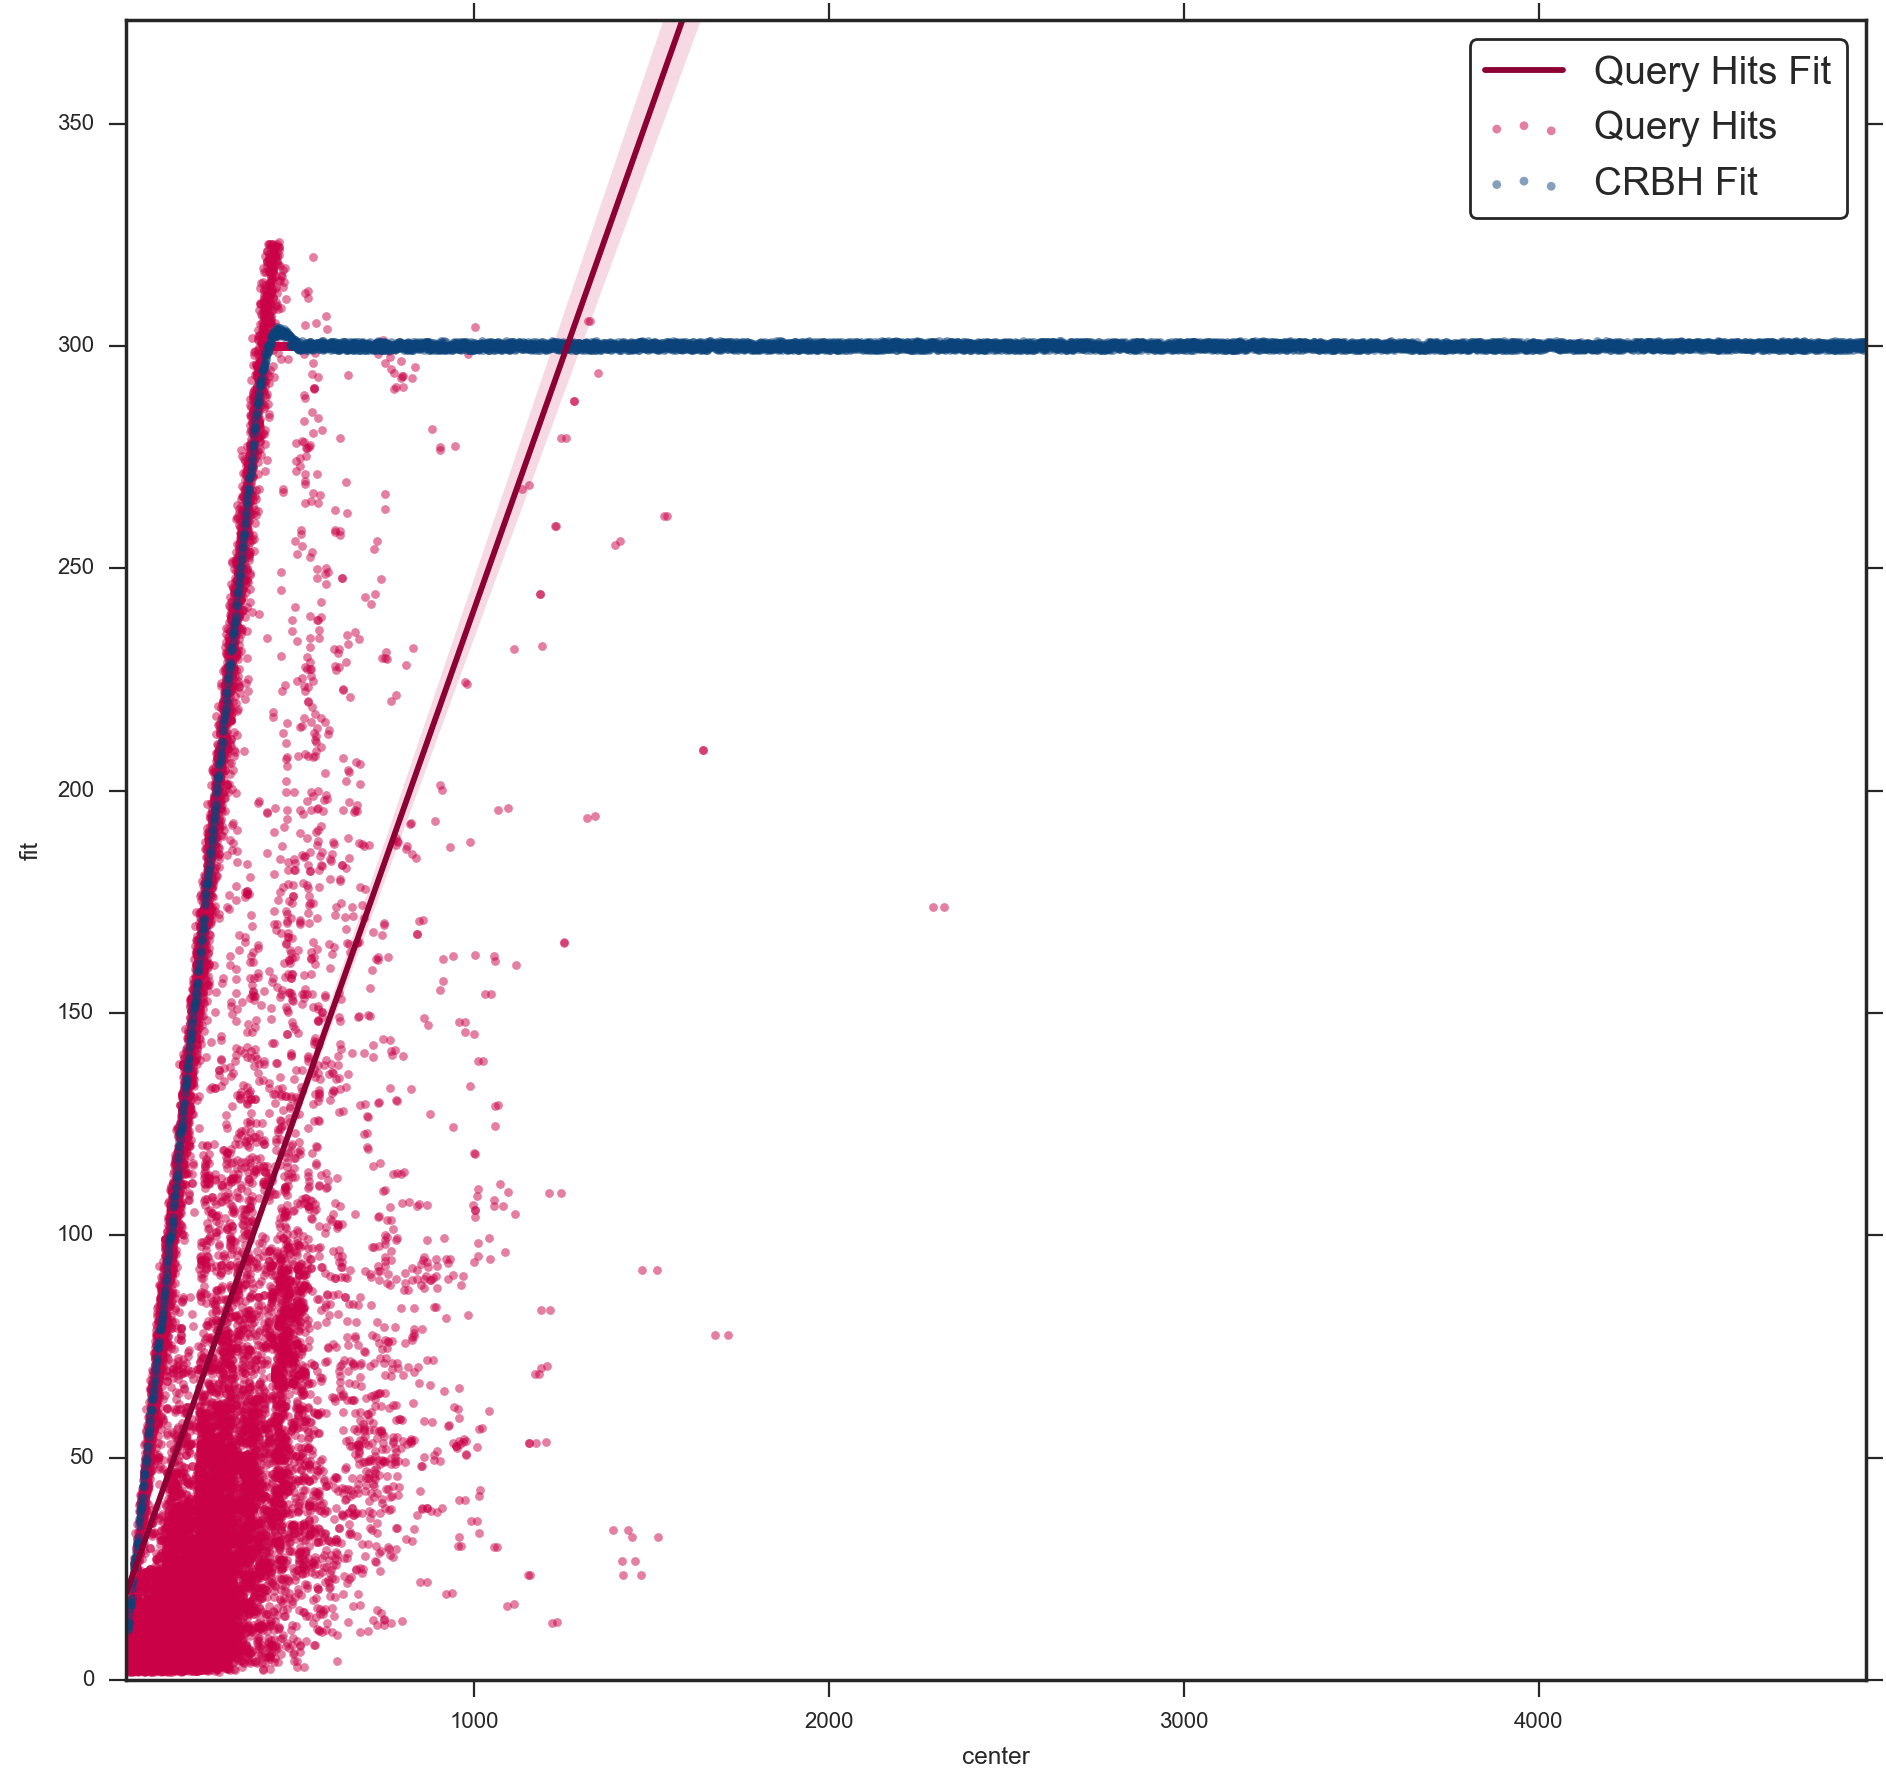

In [296]:
scatter_kws = {'s': 10, 'alpha':0.5}

scatter_kws['c'] = sns.xkcd_rgb['ruby']
scatter_kws['marker'] = 'o'
line_kws = {'c': sns.xkcd_rgb['red wine'], 'label':'Query Hits Fit'}
sns.regplot('s_aln_len', 'E', qvd_df, order=1, label='Query Hits',
            scatter_kws=scatter_kws, line_kws=line_kws, color=scatter_kws['c'])

scatter_kws['c'] = sns.xkcd_rgb['twilight blue']
scatter_kws['marker'] = 's'
sns.regplot('center', 'fit', fit.reset_index(), fit_reg=False, x_jitter=True, y_jitter=True, label='CRBH Fit',
            scatter_kws=scatter_kws, line_kws=line_kws)

leg = legend(fontsize='medium', scatterpoints=3, frameon=True)
leg.get_frame().set_linewidth(1.0)
xlim(fit.center.min(), fit.center.max())
ylim(0, max(fit['fit'].max(), qvd_df['E'].max()) + 50)